# Introduction
- ref:
    > https://www.kaggle.com/artgor/brute-force-feature-engineering
- nb10, nb12 に続いて、特徴量を増やす。
- molecule ごとを意識した特徴量を意識する

# Import evetything I nead :)

In [28]:
import glob
import multiprocessing
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

# Data Preparation

In [29]:
file_path = './input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['./input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 './input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 './input/champs-scalar-coupling/structures.csv',
 './input/champs-scalar-coupling/test.csv',
 './input/champs-scalar-coupling/dipole_moments.csv',
 './input/champs-scalar-coupling/potential_energy.csv',
 './input/champs-scalar-coupling/sample_submission.csv',
 './input/champs-scalar-coupling/train.csv',
 './input/champs-scalar-coupling/mulliken_charges.csv']

In [30]:
# train
path = file_path + 'train.csv'
train = pd.read_csv(path)

In [31]:
# test
path = file_path + 'test.csv'
test = pd.read_csv(path)

In [32]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [33]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


In [34]:
# using n_cpu
n_cpu = multiprocessing.cpu_count()-3
n_cpu

77

# Feature Engineering

**before**

In [35]:
train.head(0)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant


---
**after**
- structure から座標情報を付与

In [36]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

train.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.00215,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.00215,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644


In [37]:
# メモリの開放
del structures
gc.collect()

98

---
**距離情報の付与**

In [38]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

---
**typeの分解**
- 2JHC から、 2 を取り出す

In [39]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

In [40]:
# ここまでの特徴量
train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z', 'type_0'],
      dtype='object')

---
**現在の特徴量から、副次的な特徴量を生成**

In [41]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    return df

In [42]:
train = create_features(train)

In [43]:
test = create_features(test)

In [44]:
# ここまでの特徴量
print(f'n_features: {len(train.columns)}')
print('-------------')
train.columns

n_features: 72
-------------


Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z', 'type_0',
       'molecule_couples', 'molecule_dist_mean', 'molecule_dist_min',
       'molecule_dist_max', 'atom_0_couples_count', 'atom_1_couples_count',
       'molecule_atom_index_0_x_1_std', 'molecule_atom_index_0_y_1_mean',
       'molecule_atom_index_0_y_1_mean_diff',
       'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
       'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std',
       'molecule_atom_index_0_z_1_std', 'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_mean_diff',
       'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_max_div', 'molecule_atom_index_0_dist_min',
       'molecule_atom_index_0

## Preparation data for model

In [45]:
# 
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']
print('usig n_features:', len(good_columns))

usig n_features: 51


In [46]:
for f in ['atom_1', 'type_0', 'type']:
    if f in good_columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [47]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
X_test = test[good_columns].copy()

In [48]:
del train, test
gc.collect()

147

# Training model on selected features

In [49]:
# Configuration
TARGET = 'scalar_coupling_constant'
# CAT_FEATS = ['atom_0','atom_1']
N_ESTIMATORS = 10000
VERBOSE = 1000
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529

In [50]:
%%time
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=RANDOM_STATE)

# Setup arrays for storing results
prediction = np.zeros(len(X_test))
scores = []
feature_importance = pd.DataFrame()

# Train the model
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    model = lgb.LGBMRegressor(**lgb_params, n_estimators = N_ESTIMATORS, n_jobs = n_cpu)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric='mae',
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

    # feature importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = good_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    scores.append(mean_absolute_error(y_valid, y_pred_valid))
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    scores.append(mean_absolute_error(y_valid, y_pred_valid))
    prediction += y_pred


Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 0.9727	valid_1's l1: 1.06124
[2000]	training's l1: 0.831151	valid_1's l1: 0.978054
[3000]	training's l1: 0.741566	valid_1's l1: 0.934866
[4000]	training's l1: 0.674261	valid_1's l1: 0.906888
[5000]	training's l1: 0.620014	valid_1's l1: 0.886955
[6000]	training's l1: 0.574744	valid_1's l1: 0.871789
[7000]	training's l1: 0.536093	valid_1's l1: 0.860693
[8000]	training's l1: 0.502257	valid_1's l1: 0.851517
[9000]	training's l1: 0.471715	valid_1's l1: 0.843602
[10000]	training's l1: 0.444333	valid_1's l1: 0.837239
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.444333	valid_1's l1: 0.837239
CV mean score: 0.8372, std: 0.0000.
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 0.972187	valid_1's l1: 1.06192
[2000]	training's l1: 0.828789	valid_1's l1: 0.975649
[3000]	training's l1: 0.739158	valid_1's l1: 0.932504
[4000]	training's l1: 0.672529	valid

## Save Result

In [51]:
path_submittion = './output/' + 'nb14_submission_lgb_{}.csv'.format(np.mean(scores))
print(f'save pash: {path_submittion}')

save pash: ./output/nb14_submission_lgb_0.8367698907126849.csv


In [52]:
submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')
submittion['scalar_coupling_constant'] = prediction
submittion.to_csv(path_submittion, index=False)

In [53]:
X.iloc[0:1000, :].to_csv('./dataframe/nb14_X_sample.csv', index=None)

## Feature importance

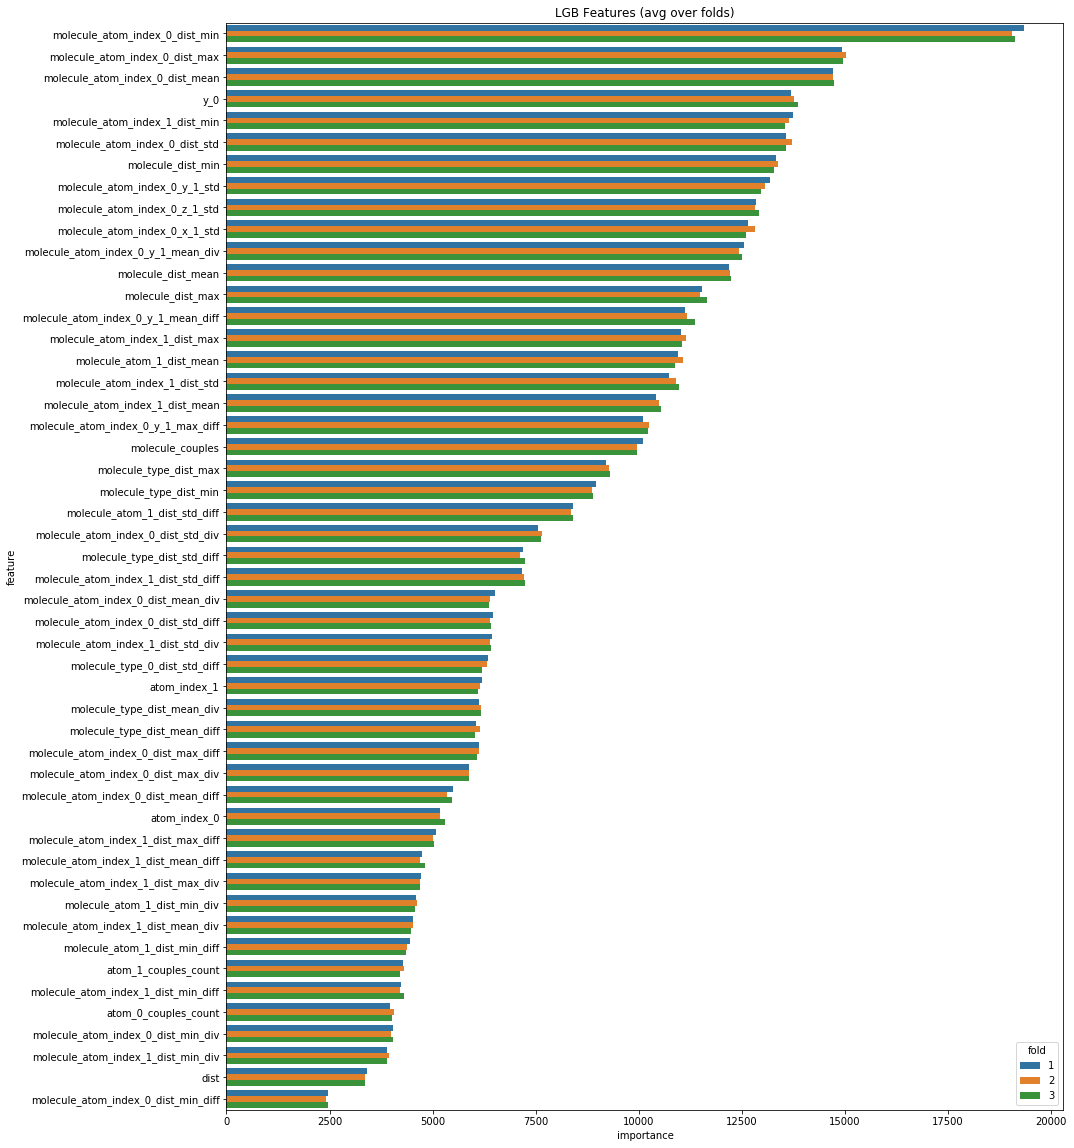

In [54]:
feature_importance["importance"] /= folds.n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(15, 20));
ax = sns.barplot(x="importance",
            y="feature",
            hue='fold',
            data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [60]:
# top 20 features
featers_fold1 = best_features[best_features['fold']==1]
featers_fold1['feature'][:20].values

array(['molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_1_dist_min',
       'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_std', 'dist',
       'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_max',
       'molecule_atom_index_1_dist_mean',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_max_div',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div', 'atom_0_couples_count',
       'molecule_atom_index_0_dist_min_div',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_0_dist_mean_div', 'atom_1_couples_count',
       'molecule_atom_index_0_dist_mean_diff', 'molecule_couples'],
      dtype=object)

In [62]:
# top 30 features
featers_fold1 = best_features[best_features['fold']==1]
featers_fold1['feature'][:30].values

array(['molecule_atom_index_0_dist_min', 'molecule_atom_index_0_dist_max',
       'molecule_atom_index_1_dist_min',
       'molecule_atom_index_0_dist_mean',
       'molecule_atom_index_0_dist_std', 'dist',
       'molecule_atom_index_1_dist_std', 'molecule_atom_index_1_dist_max',
       'molecule_atom_index_1_dist_mean',
       'molecule_atom_index_0_dist_max_diff',
       'molecule_atom_index_0_dist_max_div',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div', 'atom_0_couples_count',
       'molecule_atom_index_0_dist_min_div',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_0_dist_mean_div', 'atom_1_couples_count',
       'molecule_atom_index_0_dist_mean_diff', 'molecule_couples',
       'atom_index_1', 'molecule_dist_mean',
       'molecule_atom_index_1_dist_max_diff',
       'molecule_atom_index_0_y_1_std',
       'molecule_atom_index_1_dist_mean_diff',
       'molecule_atom_index_1_dist_std_div',
       'molecule_at